#### AI/ML directed high-throughput virtual screening of probes to selectively bind with PFOS using SDS as interferent
#### Siva Dasetty, Max Topel | Ferguson Lab


## imports

In [1]:
import os
import os.path
import sys
import importlib
import yaml

import subprocess

from time import time
from datetime import datetime

import numpy as np
import pandas as pd
import math

import scipy

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Descriptors
from rdkit.Chem.Fragments import *

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib  import cm
from PIL import Image
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

import multiprocessing

from sklearn.metrics import mean_squared_error

sys.path.append("/home/sivadasetty/scratch-midway2/pfas/analysis/NB_PFAS/activeLearning/codes/")


import utils_activeLearning_Oliver as ut

import utils_functions as utils_functions
import utils_figures as utils_figures

importlib.reload(ut)
importlib.reload(utils_functions)
importlib.reload(utils_figures)

import selfies as sf

sys.path.append("../activeLearning")
from oliver_vae.VAE import VAE_encode, VAE_decode

import torch
from torch import nn

import copy

import oapackage


#sys.path.append("/project2/andrewferguson/maxtopel/pfas/Codes")
sys.path.append("/project2/andrewferguson/sivadasetty/pfas/analysis/NB_PFAS/Codes")

import importlib
import calculateFES
importlib.reload(calculateFES)


<module 'calculateFES' from '/project2/andrewferguson/sivadasetty/pfas/analysis/NB_PFAS/Codes/calculateFES.py'>

## plot settings

In [2]:
plt.rcParams.update({'font.size': 30})

# time stamp
now = datetime.now()
now = str(now)[:10]
figures_dir = './Manuscript_Figures_JCED/{}'.format(str(now)).replace(':','-')

#### deltaG and Kb 

In [7]:
        
labelfont=20
tickfont=15
legendfont=12

m=0
temperature = 300
kT = 300*0.008314

simdir = '/project2/andrewferguson/sivadasetty/pfas/'
#simdir = '/home/sivadasetty/scratch-midway2/pfas/'


for c in [0]: ##range(0,11):
    
    t = pd.read_csv(simdir + 'analysis/NB_PFAS/MS_Figs/data-each-cycle-JCED/folder-pdb-each-cycle/jcycle-'+str(c)+'.txt',sep='\t',header=None, names=['pdb', 'smiles'])
    
    #print(t.pdb)
    #print(t.shape[1])
    
    for i in [0]: #range(t.shape[0]):
        smiles = t.smiles.values[i]
        formula = t.smiles.values[i]
        for analyte in ['pfos', 'sds']:
            
            #print(t.pdb.values[i].split('.')[0])
            
            if analyte == 'pfos':
                simDir='/project2/andrewferguson/sivadasetty/pfas'
                systemDir = '/system-pbmd/input-files-all-probes/system-pbmd-pfosd/pfosd-' + t.pdb.values[i].split('.')[0]
                colvarFile = '/pbmd-4cvs-gpu/reweight/colvar_reweight.out'
            else:
                #simDir='/project2/andrewferguson/maxtopel/pfas'
                simDir='/project2/andrewferguson/sivadasetty/pfas'
                #systemDir = '/input-files-all-probes/system-pbmd/sds-' + t.pdb.values[i].split('.')[0]
                systemDir = '/system-pbmd/input-files-all-probes/system-pbmd-sds/sds-' + t.pdb.values[i].split('.')[0]
                colvarFile = '/pbmd-gpu/reweight/colvar_reweight.out'
                
            # print if file does not exist
            if not os.path.isfile(simDir+systemDir+colvarFile):
                print("File does not exist")
                print(c, i, simDir+systemDir+colvarFile)
                print("\n")
        
            b = 100000 # first 100 ns equilibration
            e = 1000000 # 300 ns of blocks. 1 micro second data
            startBlock = b
            blockSize = 100000 * 3
            maxBlock = startBlock + blockSize
            systemFEList = []
            while maxBlock <= e:
                colvarFE = calculateFES.get_block_fes_using_cv_weights(temperature,  simDir, systemDir, 
                                                                       colvarFile, 
                                                                       ["time", "com", "htPFOS", "htProbe", "angle", "bias"], 
                                                                       0.1, 3.5, 100, "com", "bias", 2.5, startBlock, maxBlock)
                       
                startBlock = maxBlock
                maxBlock = maxBlock + blockSize
                
                systemFEList.append(colvarFE)
                
                
            avgFE, sdFE, systemFEListUpdated, fe_minList = calculateFES.get_fes_avg_sd(systemFEList, "com", 100)
          
            fe_min = 1000
            fe_min = calculateFES.find_min_avg(systemFEList[0].com.values, avgFE, fe_min)
            avgFEDF = pd.DataFrame(np.array([systemFEList[0].com.values, avgFE - fe_min, 
                                             sdFE]).transpose(), columns=["com", "avg", "sd"])
            
            minLocation, deltaFE, deltaFESD, freeBoundRegArea = calculateFES.get_delta_fe(avgFEDF, "com")
            
            #blockAvgDeltaFE, blockSDdeltaFE = calculateFES.get_delta_fe_areaMethod(systemFEListUpdated, kT, "com", 1)
            blockAvgKb, blockSDKb = calculateFES.get_Kb_areaMethod(systemFEListUpdated, kT, "com", 1)
            
            
            #print("fe_minList\n")
            #print(fe_minList)
            
            #print("Avg and SD\n")
            #print(minLocation,  deltaFE, deltaFESD)
            #print(blockAvgDeltaFE, blockSDdeltaFE)
            
            # delta G
            #bindingEnergyFileBlock='kb_deltaGRepeated_JCED/wsmiles_deltaG-linearProbesBlockArea-b3-pbmd-4cvs.txt'
            
            # new - per cycle
            #bindingEnergyFileBlock=simdir+'/analysis/NB_PFAS/MS_Figs/kb_deltaGRepeated_JCED/wsmiles_deltaG-linearProbesBlockArea-b3-pbmd-4cvs_cycle_'+str(c)+'.txt'
    
            #### WRITE TO FILE -- delta G
            #calculateFES.write_fes_tofile("PBMD-4CVs-GPU", bindingEnergyFileBlock, analyte, smiles, blockAvgDeltaFE, blockSDdeltaFE, formula)
  
            ## Kb
            #KbFileBlock='kb_deltaGRepeated_JCED/wsmiles_Kb-linearProbesBlockArea-b3-pbmd-4cvs.txt'
           
            # new - per cycle
            KbFileBlock=simdir+'/analysis/NB_PFAS/MS_Figs/kb_deltaGRepeated_JCED/wsmiles_Kb-linearProbesBlockArea-b3-pbmd-4cvs_cycle_'+str(c)+'.txt'
    

            #### WRITE TO FILE -- Kb
            #calculateFES.write_fes_tofile("PBMD-4CVs-GPU", KbFileBlock, analyte, smiles, blockAvgKb, blockSDKb, formula)
  

nsamples:  3
nsamples:  3


#### extract delta G from newly computed and compare with previously computed data

In [3]:
#### read previously computed and newly computed delta G data

simdir = '/project2/andrewferguson/sivadasetty/pfas/'


new_deltaG_data_cycle_PFOS = []
new_deltaG_data_cycle_PFOS_SD = []
new_deltaG_data_cycle_SDS = []
new_deltaG_data_cycle_SDS_SD = []

for analyte in ['PFOS', 'SDS']:
    
    for c in range(0,11):
        
        
        new_deltaG_data = pd.read_csv(simdir+'/analysis/NB_PFAS/MS_Figs/kb_deltaGRepeated_JCED/wsmiles_deltaG-linearProbesBlockArea-b3-pbmd-4cvs_cycle_'+str(c)+'.txt', delim_whitespace=True, 
                              names=["Method", "Analyte", "lprobe", "lflourines", "lhydrogen", "hhydrogen", 
                                     "hcarbons", "Probe", "Avg", "SD", "smiles", "formula"], comment="#")
        

        if analyte == 'PFOS':
            new_deltaG_data_cycle_PFOS.append(new_deltaG_data[(new_deltaG_data["Analyte"] == analyte)].Avg.values)
            new_deltaG_data_cycle_PFOS_SD.append(new_deltaG_data[(new_deltaG_data["Analyte"] == analyte)].SD.values)
        else:
            new_deltaG_data_cycle_SDS.append(new_deltaG_data[(new_deltaG_data["Analyte"] == analyte)].Avg.values)
            new_deltaG_data_cycle_SDS_SD.append(new_deltaG_data[(new_deltaG_data["Analyte"] == analyte)].SD.values)
                    
       
            
        
    

cycle: 0: 1: 0:
cycle: 1: 1: 1:
cycle: 2: 1: 2:
cycle: 3: 1: 3:
cycle: 4: 1: 4:
cycle: 5: 1: 5:
cycle: 6: 2: 0:
cycle: 7: 2: 1:
cycle: 8: 2: 2:
cycle: 9: 2: 3:
cycle: 10: 2: 4:


<Figure size 700x400 with 0 Axes>

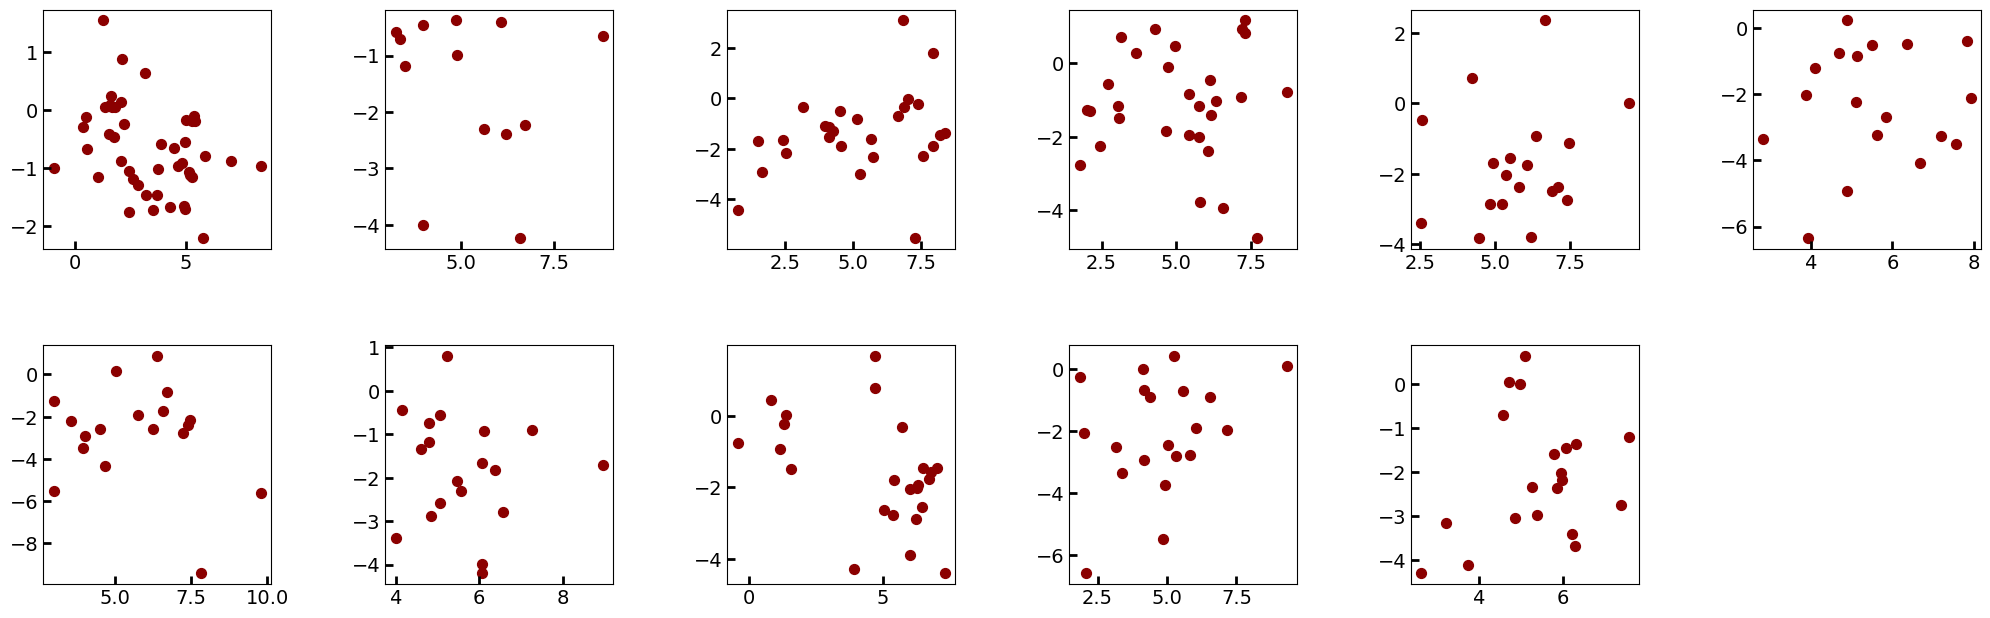

In [5]:
#deltaG_data_cycle_PFOS
mean_distance_pareto = []
mean_distance_pareto_only = []

labelfont=20
tickfont=18
legendfont=8

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=([7,4]))

#gs = gridspec.GridSpec(2,6)
#gs.update(wspace=1.5, hspace=0.3)

fig = plt.figure(figsize=[25,15])
fig.tight_layout(pad=100.0)
spec = gridspec.GridSpec(ncols=6, nrows=4)
fig.subplots_adjust(bottom=0.05, hspace=.4, wspace=.5)

ax = ['ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6', 'ax7', 'ax8', 'ax9', 'ax10', 'ax11', 'ax12', 'ax13', 'ax14']


kT = 1 #300*0.008314
preFactor = 2*kT

##############################################################################################################################################            
col=0
row=1
cycles=11
for c in range(cycles):
    
    tickfont=14
    
    if c!=0:
        if c % 6 == 0:
            col = 0
            row += 1
        else:
            col += 1
    
    print("cycle: %d: %d: %d:"% (c, row, col))
    
    #ax[c] = fig.add_subplot(2, 6, c+3)
    pc = c+2
    ax[pc] = fig.add_subplot(spec[row, col])
    ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
    ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
    ax[pc].tick_params(which='minor', direction='in', length=3, width=2)
    #spec.update(wspace=0.45, hspace=0.7)
    

    new_selectivity = np.array(new_deltaG_data_cycle_PFOS[c]).flatten() - np.array(new_deltaG_data_cycle_SDS[c]).flatten()
    new_selectivityError = np.sqrt(np.array(new_deltaG_data_cycle_PFOS_SD[c]).flatten()**2 + np.array(new_deltaG_data_cycle_SDS_SD[c]).flatten()**2)
    
    ax[pc].scatter(-np.array(new_deltaG_data_cycle_PFOS[c]).flatten()/kT, 
                  -new_selectivity/kT, 
                  color="darkred", s=50, alpha=1, marker='o', label='init')
    

    
    
    